# Models

In [59]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
import os
import ipaddress
import seaborn as sns
import matplotlib.pyplot as plt

### Chargement des données

On charge les données et on encode les variable catégorielles

In [53]:
df0=pd.read_csv("../data/final/Credential_Access.csv")
df1=pd.read_csv("../data/final/Defense_Evasion.csv")
df2=pd.read_csv("../data/final/Discovery.csv")
df3=pd.read_csv("../data/final/Exfiltration.csv")
df4=pd.read_csv("../data/final/Initial_Access.csv")
df5=pd.read_csv("../data/final/none.csv")
df6=pd.read_csv("../data/final/Persistence.csv")
df7=pd.read_csv("../data/final/Privilege_Escalation.csv")
df8=pd.read_csv("../data/final/Reconnaissance.csv")
listeDatasets=[df0,df1,df2,df3,df4,df5,df6,df7,df8]

categorical_columns = ['conn_state', 'protocol', 'service', 'history', 'label_tactic']


#Gestion des dates
for i in range(len(listeDatasets)):
    df=listeDatasets[i]
    df['ts'] = pd.to_datetime(df['ts'], unit='s')
    df['year'] = df['ts'].dt.year
    df['month'] = df['ts'].dt.month
    df['day'] = df['ts'].dt.day
    df['hour'] = df['ts'].dt.hour
    df['minute'] = df['ts'].dt.minute
    df['seconde'] = df['ts'].dt.second
    df['dayofweek'] = df['ts'].dt.dayofweek  # 0=lundi, 6=dimanche

    # Caractéristiques cycliques pour l'heure (pour préserver la nature cyclique)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

    # Caractéristiques cycliques pour le jour de la semaine
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)

    # Trier par timestamp pour calculer les différences temporelles
    df = df.sort_values('ts')
    df['time_since_last'] = df['ts'].diff().dt.total_seconds()

    # Remplacer la première valeur NaN par 0 ou une autre valeur appropriée
    df['time_since_last'] = df['time_since_last'].fillna(0)

    df=df.drop(['ts'], axis=1)

    #Gestion des adresses IP
    df['src_ip'] = df['src_ip'].apply(lambda x: int(ipaddress.ip_address(x)))
    df['dest_ip'] = df['dest_ip'].apply(lambda x: int(ipaddress.ip_address(x)))
    
    #Une IPV6 est un trop grand nombre, on ne peut pas le mettre en entier
    #On normalise donc les ip en divisant par la plus grande valeur possible (pour etre entre 0 et 1)
    df['src_ip'] = df['src_ip']/(2**128 - 1) # 2^128 est le max pour IPv6 car codée sur 128 bits
    df['dest_ip'] = df['dest_ip']/(2**128 - 1)

    df['src_ip']=df['src_ip'].astype(float)
    df['dest_ip']=df['dest_ip'].astype(float)

    """
    # Séparation de l'adresse IP en 4 colonnes
    df[['ip1', 'ip2', 'ip3', 'ip4']] = df['src_ip'].str.split('.', expand=True)

    # Conversion en entiers (optionnel)
    df[['ip1', 'ip2', 'ip3', 'ip4']] = df[['ip1', 'ip2', 'ip3', 'ip4']].astype(int)

    listeDatasets[i]=df.drop(['src_ip'], axis=1)
    """
    listeDatasets[i]=df
# Créer et stocker les encodeurs
encoders = {}

for col in categorical_columns:
    # Collecter toutes les valeurs uniques de TOUS les datasets
    all_values = pd.concat([df[col] for df in listeDatasets]).unique()
    
    # Créer et ajuster l'encodeur sur toutes les valeurs possibles
    encoders[col] = LabelEncoder().fit(all_values)
    
    # Appliquer l'encodeur à chaque dataset
    for df in listeDatasets:
        df[col] = encoders[col].transform(df[col])


Affichage de la structure d'un dataset encodé

In [54]:
print(listeDatasets[1].columns)
print(listeDatasets[7]["dest_ip"].head())

Index(['conn_state', 'duration', 'local_orig', 'local_resp', 'protocol',
       'service', 'history', 'src_ip', 'src_port', 'orig_bytes', 'orig_pkts',
       'orig_ip_bytes', 'dest_ip', 'dest_port', 'resp_bytes', 'resp_pkts',
       'resp_ip_bytes', 'missed_bytes', 'label_tactic', 'year', 'month', 'day',
       'hour', 'minute', 'seconde', 'dayofweek', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'time_since_last'],
      dtype='object')
291    7.067394e-30
318    7.067402e-30
279    7.067397e-30
268    7.067402e-30
253    7.067402e-30
Name: dest_ip, dtype: float64


### Separation des données

In [55]:
#Diviser chaque dataset en train/test (80/20)
train_dfs = []
test_dfs = []

for df in listeDatasets:
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_dfs.append(train_df)
    test_dfs.append(test_df)

#Concaténer les ensembles
combined_train = pd.concat(train_dfs)
combined_test = pd.concat(test_dfs)

print(combined_train.shape)
print(combined_test.shape)
print(combined_train.columns)

(1712479, 31)
(428126, 31)
Index(['conn_state', 'duration', 'local_orig', 'local_resp', 'protocol',
       'service', 'history', 'src_ip', 'src_port', 'orig_bytes', 'orig_pkts',
       'orig_ip_bytes', 'dest_ip', 'dest_port', 'resp_bytes', 'resp_pkts',
       'resp_ip_bytes', 'missed_bytes', 'label_tactic', 'year', 'month', 'day',
       'hour', 'minute', 'seconde', 'dayofweek', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'time_since_last'],
      dtype='object')


### Entrainement du modèle

In [57]:
features = ['conn_state', 'duration', 'local_orig', 'local_resp', 'protocol',
       'service', 'history','src_ip',  'src_port', 'orig_bytes', 'orig_pkts',
       'orig_ip_bytes', 'dest_ip', 'dest_port', 'resp_bytes', 'resp_pkts',
       'resp_ip_bytes', 'missed_bytes', 'year', 'month', 'day',
       'hour', 'minute', 'seconde', 'dayofweek', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'time_since_last']

label='label_tactic'

# Préparer X et y
X_train = combined_train[features]
y_train = combined_train[label]
X_test = combined_test[features]
y_test = combined_test[label]

# Créer les datasets LightGBM
categorical_indices = [features.index(col) for col in categorical_columns[:-1] ]#On recupere l'index de chaque colonne catégorielle (sauf le label)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_indices)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)



# 9. Paramètres LightGBM
num_classes = len(encoders['label_tactic'].classes_)
params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbose': -1
}

# 10. Entraîner le modèle
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[test_data],
)


### Evaluation du modèle

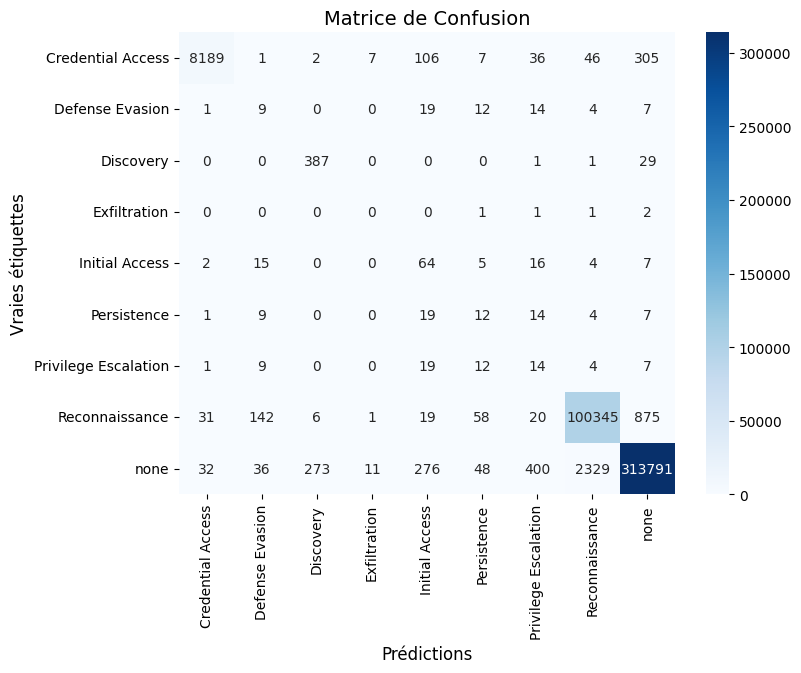


Rapport de classification:
                      precision    recall  f1-score   support

   Credential Access       0.99      0.94      0.97      8699
     Defense Evasion       0.04      0.14      0.06        66
           Discovery       0.58      0.93      0.71       418
        Exfiltration       0.00      0.00      0.00         5
      Initial Access       0.12      0.57      0.20       113
         Persistence       0.08      0.18      0.11        66
Privilege Escalation       0.03      0.21      0.05        66
      Reconnaissance       0.98      0.99      0.98    101497
                none       1.00      0.99      0.99    317196

            accuracy                           0.99    428126
           macro avg       0.42      0.55      0.45    428126
        weighted avg       0.99      0.99      0.99    428126



In [64]:
# 11. Évaluer le modèle
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_class = np.argmax(y_pred, axis=1)

# Reconvertir en labels textuels pour l'évaluation
y_pred_labels = encoders['label_tactic'].inverse_transform(y_pred_class)
y_test_labels = encoders['label_tactic'].inverse_transform(y_test)

# Afficher les résultats
from sklearn.metrics import classification_report, confusion_matrix
cm=confusion_matrix(y_test, y_pred_class)

labels = np.unique(y_test_labels)

# Afficher sous forme de heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels , yticklabels=labels)
#annot= affichage des valeurs dans les carrés  fmt = formatage des valeurs, d = entier (par exemple si c'est 0.87, il sera affiché 1).

# Ajouter les labels APRÈS avoir tracé la heatmap
ax.set_xlabel('Prédictions', fontsize=12)
ax.set_ylabel('Vraies étiquettes', fontsize=12)
ax.set_title('Matrice de Confusion', fontsize=14)
plt.show()



print("\nRapport de classification:")
print(classification_report(y_test_labels, y_pred_labels))

# Sauvegarder le modèle et les encodeurs
import pickle
model_package = {
    'model': gbm,
    'encoders': encoders,
    'features': features
}

with open('lightgbm_model_package.pkl', 'wb') as f:
    pickle.dump(model_package, f)

        src_ip  ip1  ip2  ip3  ip4
0  143.88.1.18  143   88    1   18
1  192.168.0.1  192  168    0    1
2   10.0.0.255   10    0    0  255
